In [ ]:
''' final weight saved file name : model_fcn_t3_10'''
#!pip install httplib2==0.15.0
#!pip install google-api-python-client==1.6
!pip install openexr

import pickle
import Imath
from PIL import Image
import array
import numpy as np
import json
import OpenEXR

''' what gpu'''
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


# Importing Modules here
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras import models,layers,optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection  import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from keras.models import Input
#%tensorflow_version 1.x
from keras.layers import Conv2D,MaxPooling2D,Conv1D,Cropping2D,Concatenate
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.initializers import RandomNormal
from keras.layers import Concatenate
from keras.models import load_model
from keras.initializers import RandomNormal

from google.colab import drive
drive.mount('/content/drive')
import torch
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# below steps are vital to save weights in drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)


Sat Apr  9 00:09:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
''' this cell handles the data breaking down and storing in numpy'''
''' NOTE it only has to be run once'''

# read the exr files and seperate the channels
import cv2
def exr2numpy(exr_path, chanel_name):
    file = OpenEXR.InputFile(exr_path)
    dw = file.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)
    
    Float_Type = Imath.PixelType(Imath.PixelType.FLOAT)
    
    channel_str = file.channel(chanel_name, Float_Type)
    
    channel = np.fromstring(channel_str, dtype = np.float32).reshape(size[1],-1)
    return(channel)

def labels_to_pickle(saved_filename,n=200):
    data=[]
    for i in range(200):
        print('Coverting Image '+str(i))
        filename='drive/My Drive/CameraTop/ObjectIdx'+("%04d" % i)+'.exr' 
        img = exr2numpy(filename, chanel_name= 'R')
        img=np.array(img)
        img=cv2.resize(img, (640,540))
        ''' break into patches '''
        size=100
        x_1,x_2=0,0
        y_1,y_2=0,0
        for i in range(0,10):
            #slide left to right
            y_1=size*i
            y_2=224+y_1
            if(y_2>=img.shape[1]):
                y_2=img.shape[1]
                y_1=y_2-224
                data.append(img[x_1:x_2,y_1:y_2])
                break
            for j in range(0,10):
                
                x_1=size*j
                x_2=224+x_1
                if(x_2>=img.shape[0]):
                    x_2=img.shape[0]
                    x_1=x_2-224
                    data.append(img[x_1:x_2,y_1:y_2])
                    break
                else:
                    data.append(img[x_1:x_2,y_1:y_2])

    #dump in pickle
    data=np.array(data)
    with open("drive/My Drive/"+saved_filename+".pkl", 'wb') as f:
          pickle.dump(data, f)



# stores the patches created in numpy array 
def load_and_save_training_eg(saved_filename,path='drive/My Drive/CameraTop/Image',n=200):
    
    data=[]
    for g in range(0,n):
        
        img=cv2.imread(path+("%04d" % g)+'.png') 
        img=cv2.resize(img, (640,540)) 
        ''' break into patches '''
        size=100
        x_1,x_2=0,0
        y_1,y_2=0,0
        for i in range(0,10):  
            #slide left to right
            y_1=size*i
            y_2=224+y_1
            if(y_2>=img.shape[1]):
                y_2=img.shape[1]
                y_1=y_2-224
                data.append(img[x_1:x_2,y_1:y_2])
                break
            for j in range(0,10):
                
                x_1=size*j
                x_2=224+x_1
                if(x_2>=img.shape[0]):
                    x_2=img.shape[0]
                    x_1=x_2-224
                    data.append(img[x_1:x_2,y_1:y_2])
                    break
                else:
                    data.append(img[x_1:x_2,y_1:y_2])
                     
    data=np.array(data)
    #dump data in a pickel file
    with open("drive/My Drive/"+saved_filename+".pkl", 'wb') as f:
                    pickle.dump(data, f)



#create training data X
load_and_save_training_eg('training_labels',path='drive/My Drive/CameraTop/Image',n=200)
#create testing data labels Y
labels_to_pickle('training_labels',n=200)

In [ ]:
'''Load data'''

import pickle
with open("drive/My Drive/Assesment_labels_1_200_patched.pkl", 'rb') as f:
                    Y=pickle.load( f)
with open("drive/My Drive/training_examples_patched.pkl", 'rb') as f:
                    X=pickle.load( f)    
                    
X_seperate=X.copy()
Y_seperate=Y.copy()

'''Split Data'''
#splting in 80 to 20 ratio
# I am multiplying it by 26 becasue I want wholesome images in both training and test set.
x_train, x_test, y_train, y_test = X[:26*160],X[26*160:],Y[:26*160],Y[26*160:]
print('x_train.shape= {}'.format(x_train.shape))
print('y_train.shape= {}'.format(y_train.shape))
print('x_test.shape= {}'.format(x_test.shape))
print('y_test.shape= {}'.format(y_test.shape))


''' encode data'''
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

print('y_train_c.shape= {}'.format(y_train_c.shape))
#print('y_test_c.shape= {}'.format(y_test_c.shape))


In [ ]:
# this function pastes patch to its place
def patch_paste(big_image_piece,patch):
    
    for i in range(224):
        for j in range(224):
            if(big_image_piece[i][j]==-1):
                big_image_piece[i][j]=patch[i][j]
            else:
                big_image_piece[i][j]=(patch[i][j]+big_image_piece[i][j])/2
                
    return big_image_piece
    
    
# data will be of size (no_of_patches_of_each_image,224,224)
#this function is used to reconstruct the image from patches
def image_reconstruction(data, original_image_size=(640,540),size=100):
    img=np.zeros((original_image_size[1],original_image_size[0]))-1
    size=size
    x_1,x_2=0,0
    y_1,y_2=0,0
    patch_no=0
    for i in range(0,100):
        #slide left to right
        y_1=size*i
        y_2=224+y_1
        if(y_2>=img.shape[1]):
            y_2=img.shape[1]
            y_1=y_2-224
            img[x_1:x_2,y_1:y_2]= patch_paste(img[x_1:x_2,y_1:y_2] ,data[patch_no])
            patch_no=patch_no+1
            #print('x_1 :{}, x_2 :{}, y_1 :{}, y_2:{} '.format(x_1,x_2,y_1,y_2))
            break
        for j in range(0,100):
            x_1=size*j
            x_2=224+x_1
            if(x_2>=img.shape[0]):
                x_2=img.shape[0]
                x_1=x_2-224
                img[x_1:x_2,y_1:y_2]=patch_paste(img[x_1:x_2,y_1:y_2] ,data[patch_no])
                patch_no=patch_no+1
                #print('x_1 :{}, x_2 :{}, y_1 :{}, y_2:{} '.format(x_1,x_2,y_1,y_2))
                break
            else:
                img[x_1:x_2,y_1:y_2]= patch_paste(img[x_1:x_2,y_1:y_2] ,data[patch_no])
                patch_no=patch_no+1
                #print('x_1 :{}, x_2 :{}, y_1 :{}, y_2:{} '.format(x_1,x_2,y_1,y_2))
    plt.imshow(img)
    plt.show()
    
class my_model():
  def __init__(self):
    print('Model Initializing...')
    

  def FCN_encoder(self,x):

      x=layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x) 
      x=layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
      p1=layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)

      x=layers.Conv2D(128, (3, 3), padding="same", activation="relu")(p1)
      x=layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
      p2=layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)

      x=layers.Conv2D(256, (3, 3), padding="same", activation="relu")(p2)
      x=layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
      x=layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
      p3=layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)

      x=layers.Conv2D(512, (3, 3), padding="same", activation="relu")(p3)
      x=layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
      x=layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
      p4=layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)


      x=layers.Conv2D(1024, (3, 3), padding="same", activation="relu")(p4)
      x=layers.Conv2D(1024, (3, 3), padding="same", activation="relu")(x)
      x=layers.Conv2D(1024, (3, 3), padding="same", activation="relu")(x)
      p5=layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)

      return p1,p2,p3,p4,p5

  def FCN(self,x,n_classes):
    op=layers.Conv2D(n_classes,(1,1),strides=1,activation="relu",kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                                kernel_regularizer = tf.keras.regularizers.L2(1e-3))(x)
    return op

  def FCN_decoder(self,p1,p2,p3,p4,p5,n_classes=9):

    encoder_out= self.FCN(p5,n_classes)
    # num_classes. num_classes should be 2 for this project -- a
    # Transposed/backward convolutions for creating a decoder
    deconv_1 = layers.Conv2DTranspose( n_classes, 4, 2, 'SAME', kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01) ,
                                      kernel_regularizer = keras.regularizers.l2(1e-3))(encoder_out)
    
    # Add a skip connection to previous VGG layer

    skip_1= self.FCN(p4,n_classes)
    add1=layers.Add()([deconv_1,skip_1])

    # Up-sampling
    deconv_2 = layers.Conv2DTranspose( n_classes, 4, 2, 'SAME', kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01),
                                kernel_regularizer = keras.regularizers.L2(1e-3))(add1)

    skip_2 = self.FCN(p3,n_classes)
    add2=layers.Add()([deconv_2,skip_2])

    deconv_3 = layers.Conv2DTranspose(n_classes, 16, 8, 'SAME', kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01),
                                kernel_regularizer = keras.regularizers.L2(1e-3))(add2 )
    
    return deconv_3

  def make_model(self,input_shape=(224,224,3)):

      input=Input(shape=input_shape)
      p1,p2,p3,p4,p5=self.FCN_encoder(input) # encoder
      output=self.FCN_decoder(p1,p2,p3,p4,p5) # decoder
      final_output=layers.Activation('softmax')(output)

      model=models.Model(input,final_output)
    
      model.compile(optimizer=tf.keras.optimizers.Adam( learning_rate=0.001) ,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
      return model


class TrainingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        pass
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    def on_train_batch_begin(self, batch, logs=None):
        pass
        
    def on_train_batch_end(self, batch, logs=None):
        pass
        
    def display(self,img):
          plt.imshow(np.round(np.argmax(img, axis=2, out=None)))

    def on_epoch_end(self, epoch, logs=None):
        if (epoch%10==0):
          print(f"Finished epoch {epoch}, loss is {logs['loss']}, accuracy is {logs['accuracy']}")
          print('predicting and showing the result....')
          im=fcn_model.predict(x_train[990:1000])
          #dic.append(im[0])
          cv2_imshow((np.round(np.argmax(im[8], axis=2, out=None)))*255.)
          #cv2_imshow((np.round(im[0])*255))
          # save model weights
          print('Saving model...')
          filename='drive/My Drive/Model_fcn_t2_'+str(epoch)+'.h5' 
          fcn_model.save(filename)

    def on_train_end(self, logs=None):
        print("Finished training")



#make the model
m=my_model()
fcn_model=m.make_model(input_shape=(224,224,3))
#enable to print summary
fcn_model.summary()

Model Initializing...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                       

In [ ]:
#FIT model

def alpha_changer(epoch,lr,val_loss=None):
  if (epoch==20):
    return lr/10.0
  else :
    return lr

#lr_callback=callback=keras.callbacks.LearningRateScheduler(alpha_changer)



history_2=fcn_model.fit(x_train, y_train_c,batch_size=52,epochs=1000, validation_split=0.1,callbacks=[TrainingCallback()]) 

#model.evaluate(x_test, y_test_c)
#preds=model.predict(x_test)

Starting epoch 0
Epoch 1/1000
72/72 [==============================] - ETA: 0s - loss: 0.9051 - accuracy: 0.8070

In [ ]:
'''Re training the saved modle from checkpoint'''

#this funciton changes the alpha slowly
def alpha_changer(epoch,lr,val_loss=None):
  if (epoch%10==0):
    print('learning rate changed....')
    return lr/10.0
  else :
    return lr

lr_callback=keras.callbacks.LearningRateScheduler(alpha_changer)

class TrainingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        pass
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    def on_train_batch_begin(self, batch, logs=None):
        pass
        
    def on_train_batch_end(self, batch, logs=None):
        pass
        
    def display(self,img):
          plt.imshow(np.round(np.argmax(img, axis=2, out=None)))

    def on_epoch_end(self, epoch, logs=None):
        if (epoch%10==0):
          print(f"Finished epoch {epoch}, loss is {logs['loss']}, accuracy is {logs['accuracy']}")
          print('predicting and showing the result....')
          im=model_fcn_t3_10.predict(x_train[990:1000])
          #dic.append(im[0])
          cv2_imshow((np.round(np.argmax(im[8], axis=2, out=None)))*255.)
          #cv2_imshow((np.round(im[0])*255))
          # save model weights
          print('Saving model...')
          filename='drive/My Drive/Model_fcn_t3_'+str(epoch)+'.h5' 
          model_fcn_t3_10.save(filename)

    def on_train_end(self, logs=None):
        print("Finished training")

model_fcn_t3_10 = models.load_model('drive/My Drive/Model_fcn_t3_10.h5')
model_fcn_t3_10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


# to see the test acceracy
model_fcn_t3_10.evaluate(x_test, y_test_c)

#history_2=model_fcn_20.fit(x_train, y_train_c,batch_size=52,epochs=1000, validation_split=0.1,callbacks=[TrainingCallback(),lr_callback]) 

33/33 [==============================] - 14s 120ms/step - loss: 0.0931 - accuracy: 0.9878


[0.09313610196113586, 0.9878478050231934]

original


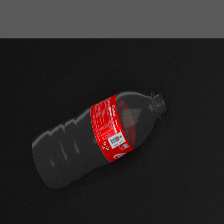

Predicted...


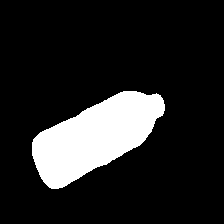

Actual....


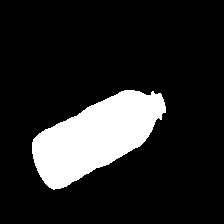

original


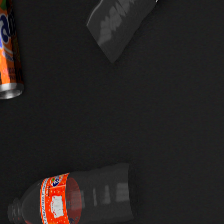

Predicted...


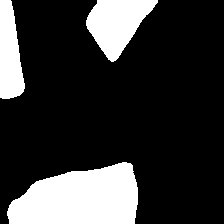

Actual....


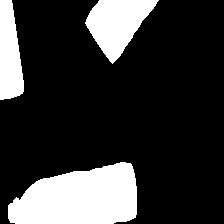

original


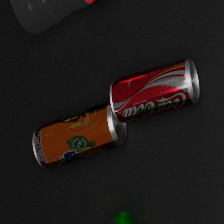

Predicted...


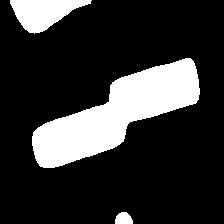

Actual....


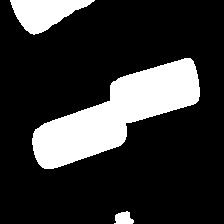

original


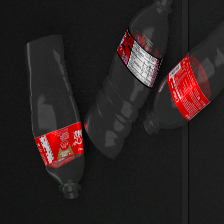

Predicted...


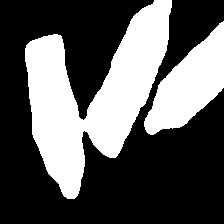

Actual....


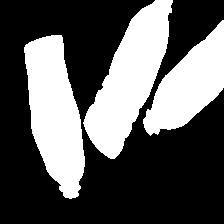

original


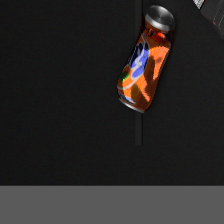

Predicted...


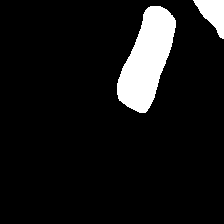

Actual....


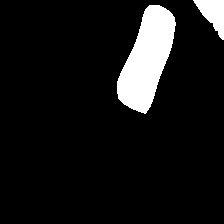

original


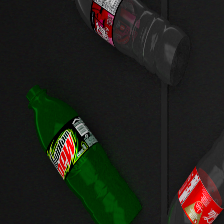

Predicted...


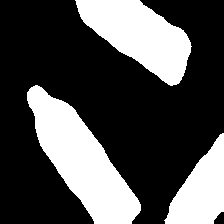

Actual....


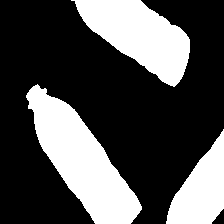

original


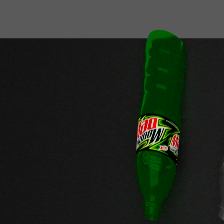

Predicted...


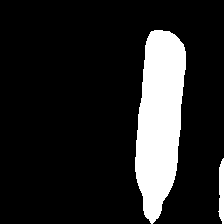

Actual....


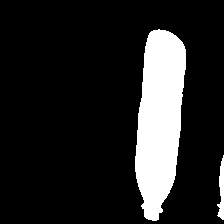

original


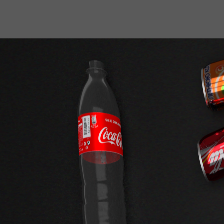

Predicted...


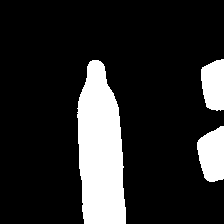

Actual....


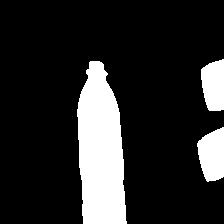

original


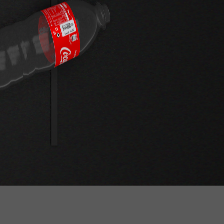

Predicted...


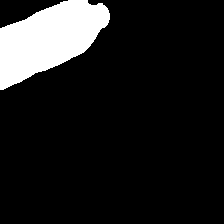

Actual....


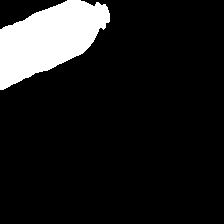

original


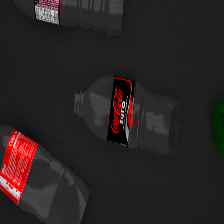

Predicted...


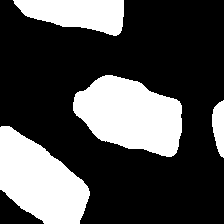

Actual....


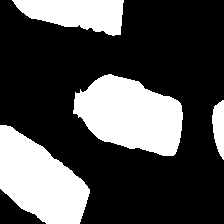

original


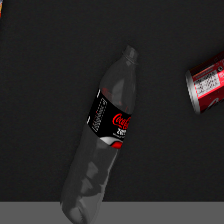

Predicted...


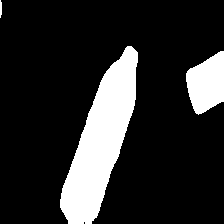

Actual....


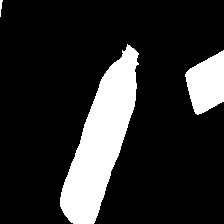

original


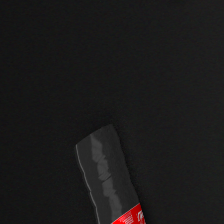

Predicted...


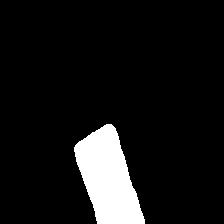

Actual....


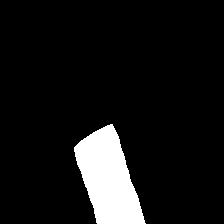

original


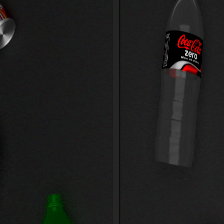

Predicted...


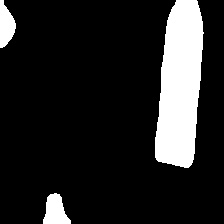

Actual....


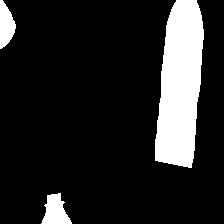

original


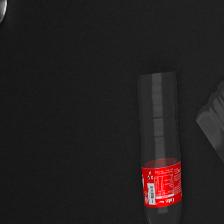

Predicted...


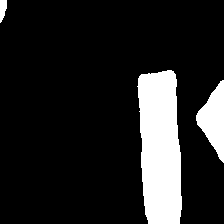

Actual....


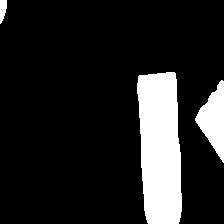

original


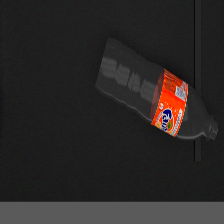

Predicted...


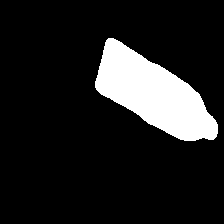

Actual....


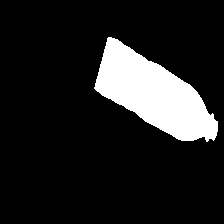

original


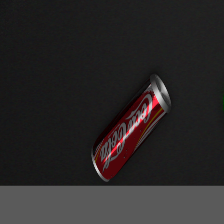

Predicted...


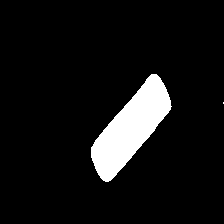

Actual....


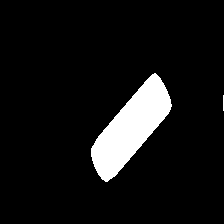

original


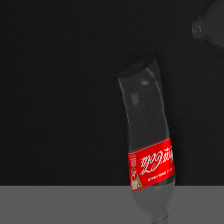

Predicted...


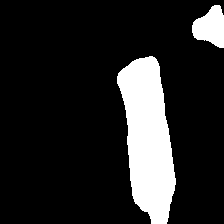

Actual....


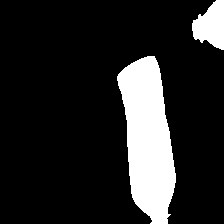

original


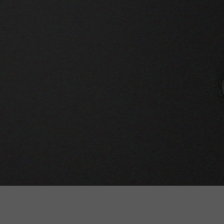

Predicted...


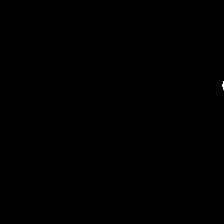

Actual....


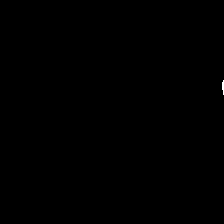

original


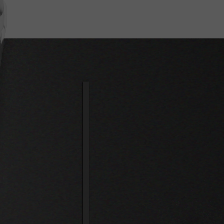

Predicted...


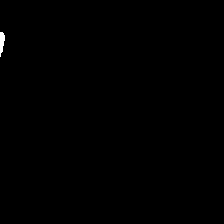

Actual....


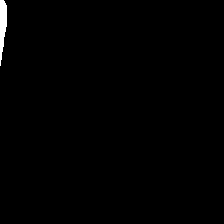

original


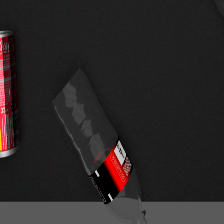

Predicted...


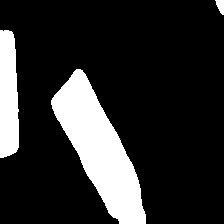

Actual....


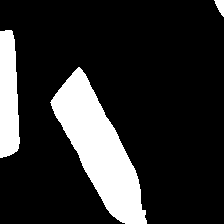

original


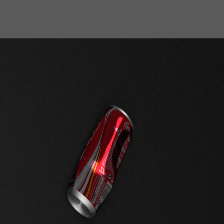

Predicted...


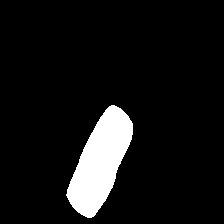

Actual....


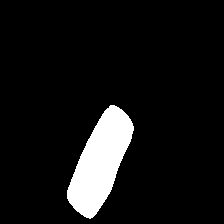

original


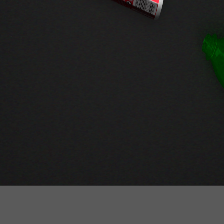

Predicted...


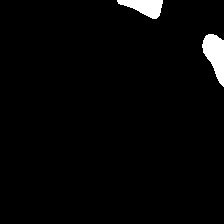

Actual....


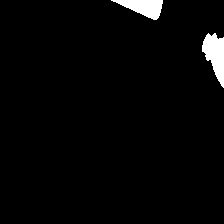

original


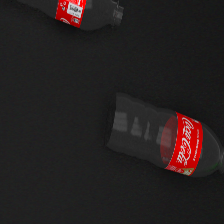

Predicted...


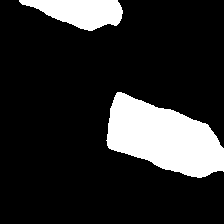

Actual....


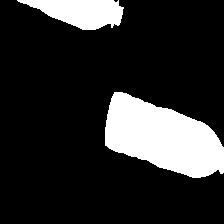

original


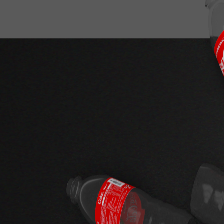

Predicted...


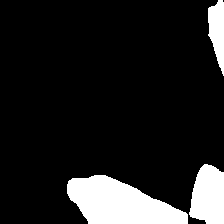

Actual....


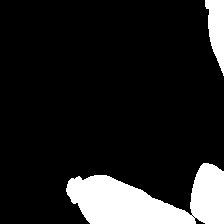

original


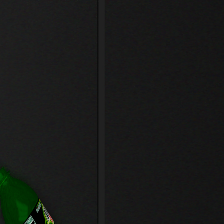

Predicted...


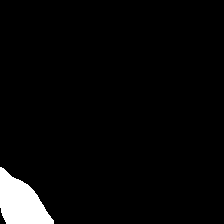

Actual....


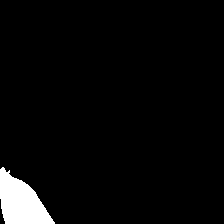

original


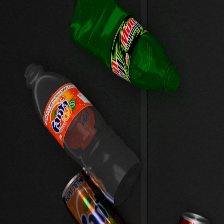

Predicted...


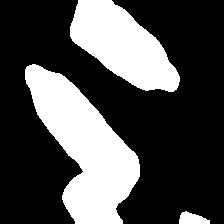

Actual....


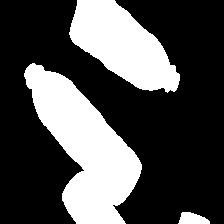

In [ ]:
example_no=1
dat=model_fcn_t3_10.predict(x_test[26*example_no:(26*example_no)+26])
da_a=[]
da_x=[] 
for label in y_test_c[26*example_no:(26*example_no)+26]:
  da_a.append(label)
da=[]
for i in range(26):
  print('original')
  cv2_imshow(x_test[26*example_no:(26*example_no)+26][i])
  print('Predicted...')
  cv2_imshow( np.round(np.argmax(dat[i], axis=2, out=None))*255 )
  print('Actual....')
  cv2_imshow( np.round(np.argmax(da_a[i], axis=2, out=None))*255 )

Predicted...


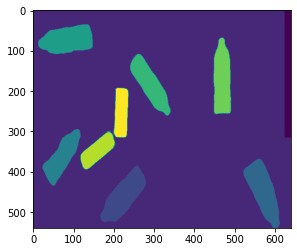

Actual....


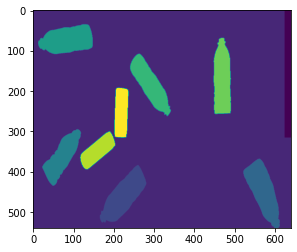

In [ ]:
#Lets test some predicted parts
example_no=10
dat=model_fcn_t3_10.predict(X_seperate[26*example_no:(26*example_no)+26])
da=[]
for i in range(26):
  da.append(np.round(np.argmax(dat[i], axis=2, out=None)))

print('Predicted...')
image_reconstruction(da)
print('Actual....')
image_reconstruction(Y_seperate[26*example_no:(26*example_no)+26])

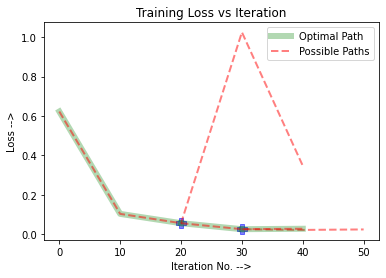

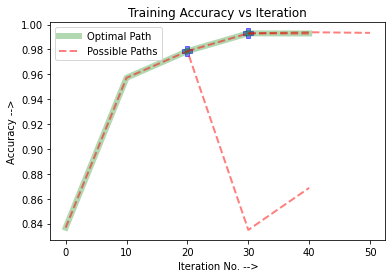

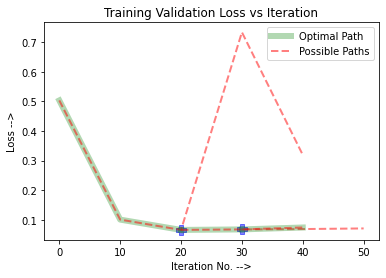

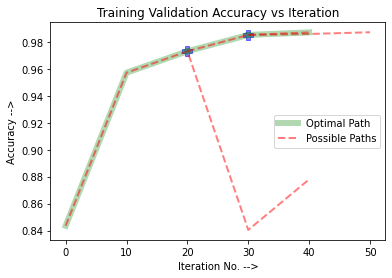

In [ ]:
# tracks the training accuracy and loss
# here data is stored from the observation of truncated training
data_t1=[{'loss': 0.6225 , 'accuracy': 0.8367 , 'val_loss': 0.5032 , 'val_accuracy': 0.8436},
         {'loss': 0.1024 , 'accuracy': 0.9572 , 'val_loss': 0.1010 , 'val_accuracy': 0.9571},
         {'loss': 0.0551 , 'accuracy': 0.9786 , 'val_loss': 0.0662 , 'val_accuracy': 0.9730},
         {'loss': 1.0254 , 'accuracy': 0.8349 , 'val_loss': 0.7333 ,'val_accuracy': 0.8405},
         {'loss': 0.3467 ,'accuracy': 0.8687 , 'val_loss': 0.3192 , 'val_accuracy': 0.8780}]

data_t2=[ {'loss': 0.0551 , 'accuracy': 0.9786 , 'val_loss': 0.0662 , 'val_accuracy': 0.9730},
         {'loss': 0.0246 , 'accuracy': 0.9929 , 'val_loss': 0.0679 , 'val_accuracy': 0.9851},
         {'loss': 0.0209 , 'accuracy': 0.9938 , 'val_loss': 0.0691 , 'val_accuracy': 0.9858},
         {'loss': 0.0233 , 'accuracy': 0.9933 , 'val_loss': 0.0712 , 'val_accuracy': 0.9871}]

data_t3=[{'loss': 0.0246 , 'accuracy': 0.9929 , 'val_loss': 0.0679 , 'val_accuracy': 0.9851},
         {'loss': 0.0268 , 'accuracy': 0.9928 , 'val_loss': 0.0744 , 'val_accuracy': 0.9870}]



def plot_training_graph(data_t1, data_t2,data_t3, key='loss',title="Training Loss vs Iteration",ylabel='Loss -->'):

    #data_t1
    t1={'loss': [] , 'accuracy': [] , 'val_loss': [] , 'val_accuracy': []}
    for model in data_t1:
        t1[key].append(model[key])

    #data_t2
    t2={'loss': [] , 'accuracy': [] , 'val_loss': [] , 'val_accuracy': []}
    for model in data_t2:
        t2[key].append(model[key])
    
    #data_t2
    t3={'loss': [] , 'accuracy': [] , 'val_loss': [] , 'val_accuracy': []}
    for model in data_t3:
        t3[key].append(model[key])

    t1_itr=[0,10,20,30,40]
    t2_itr=[20,30,40,50]
    t3_itr=[30,40]
    overlapping_red = 0.5
    overlapping_green = 0.3
    lw_red=2
    lw_green=6
    #loss
    plt.plot(t1_itr[:3],t1[key][:3], color='green',alpha=overlapping_green,lw=lw_green)
    plt.plot(t1_itr,t1[key],'--', color='red',alpha=overlapping_red,lw=lw_red)
    plt.legend(['Optimal Path','Possible Paths'])

    plt.plot(t2_itr[:2],t2[key][:2] ,color='green',alpha=overlapping_green,lw=lw_green)
    plt.plot(t2_itr,t2[key],'--' ,color='red',alpha=overlapping_red,lw=lw_red)

    plt.plot(t3_itr,t3[key], color='green',alpha=overlapping_green,lw=lw_green)
    plt.plot(t3_itr,t3[key],'--', color='red',alpha=overlapping_red,lw=lw_red)

    # plot the checkpoints
    plt.scatter(t1_itr[2],t1[key][2],s=100,marker='P',color='blue',alpha=0.5)
    plt.scatter(t2_itr[1],t2[key][1],s=100,marker='P',color='blue',alpha=0.5)
    #plt.yticks([0,0.1,0.2,0.6,0.8,1.0])

    plt.title(title)
    
    plt.xlabel('Iteration No. -->')
    plt.ylabel(ylabel)
    plt.show()

plot_training_graph(data_t1, data_t2,data_t3, key='loss',title="Training Loss vs Iteration",ylabel='Loss -->')
plot_training_graph(data_t1, data_t2,data_t3, key='accuracy',title="Training Accuracy vs Iteration",ylabel='Accuracy -->')
plot_training_graph(data_t1, data_t2,data_t3, key='val_loss',title="Training Validation Loss vs Iteration",ylabel='Loss -->')
plot_training_graph(data_t1, data_t2,data_t3, key='val_accuracy',title="Training Validation Accuracy vs Iteration",ylabel='Accuracy -->')